In [1]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import lightgbm as lgb

from source import utility as ut
from source import transform as tr
from source.train import train_model
from source.report import plot_regression_predictions, plot_learning_curve, plot_feat_imp, plot_partial_dependence

pd.set_option('max_columns', 100)

In [6]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
subs = pd.read_csv('data/sample_submission.csv')

train_set, test_set = ut.make_test(df_train, 0.25, random_state=516, strat_feat='cat9')

del train_set['id']
del test_set['id']

y = train_set['target'].copy()
del train_set['target']
y_test = test_set['target'].copy()
del test_set['target']

for col in [col for col in train_set if 'cat' in col]:
    le = LabelEncoder()
    train_set[col] = le.fit_transform(train_set[col])
    test_set[col] = le.transform(test_set[col])

In [3]:
train_mean = np.mean(y)
print(f'True Baseline OOF: {round(np.sqrt(mean_squared_error(y, [train_mean]*len(y))), 4)}')
print(f'True Baseline Test: {round(np.sqrt(mean_squared_error(y_test, [train_mean]*len(y_test))), 4)}')

True Baseline OOF: 0.887
True Baseline Test: 0.8883


In [4]:
train_median = np.median(y)
print(f'True Baseline OOF: {round(np.sqrt(mean_squared_error(y, [train_median]*len(y))), 4)}')
print(f'True Baseline Test: {round(np.sqrt(mean_squared_error(y_test, [train_median]*len(y_test))), 4)}')

True Baseline OOF: 0.8879
True Baseline Test: 0.8894


In [24]:
class Iterator:
    def __init__(self, train, test, target_cols, seeds, n_folds, train_args, test_target=None, verbose=False):
        self.train = train
        self.test = test
        self.target_cols = target_cols
        self.seeds = seeds
        self.n_folds = n_folds
        self.train_args = train_args
        self.verbose = verbose
        self.test_target = test_target
        

    def it_seeds(self):

        oof = np.zeros(len(self.train))
        predictions = np.zeros(len(self.test))

        for seed in self.seeds:
            if self.verbose:
                print(f"SEED: {seed}")
                
            folds = KFold(self.n_folds, shuffle=True, random_state=seed)

            oof_seed, predictions_seed, rep_res_seed = train_model(train_df=self.train, test_df=self.test, target=self.target_cols, 
                                                                   cv=folds, **self.train_args)
            
            if self.verbose:
                print(f'\tIteations for early stopping: {rep_res_seed["n_iterations"]}')

                print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(self.target_cols, oof_seed)), 4)}')
                if self.test_target is not None:
                    print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(self.test_target, predictions_seed)), 4)}')
            
            oof += oof_seed / len(self.seeds)
            predictions += predictions_seed / len(self.seeds)
            
        if self.verbose:
            print(f'Train set RMSE: {round(np.sqrt(mean_squared_error(self.target_cols, oof)), 4)}')
            if self.test_target is not None:
                print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(self.test_target, predictions)), 4)}')

        return oof, predictions

In [25]:
SEEDS = [541, 75]

SEED: 541
	Iteations for early stopping: [2048, 1788, 1841, 2135, 1792, 2194, 2570, 2157, 1901, 2178]
	Train set RMSE: 0.8422
	Test set RMSE: 0.8428
SEED: 75
	Iteations for early stopping: [1816, 2161, 2324, 1517, 2388, 2219, 2041, 1803, 1841, 2180]
	Train set RMSE: 0.8423
	Test set RMSE: 0.8428
Train set RMSE: 0.842
Test set RMSE: 0.8428


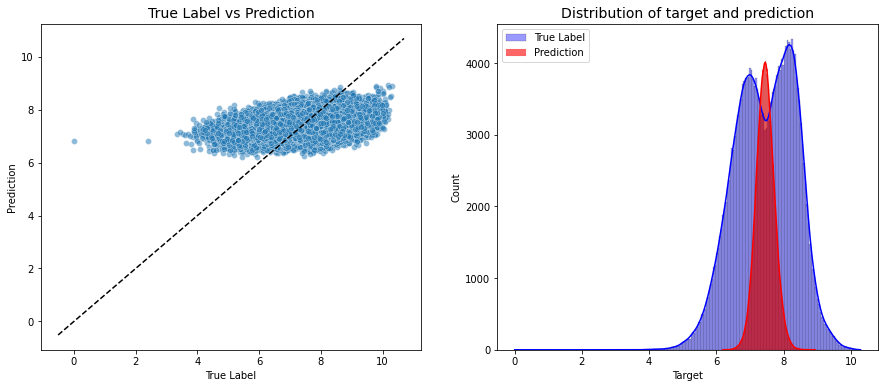

CPU times: user 48min 53s, sys: 12.8 s, total: 49min 6s
Wall time: 9min 57s


In [27]:
%%time

params = { 'random_state':42, 
          'metric': 'rmse', 
          'n_jobs': 5, 
          #'cat_feature': [x for x in range(len(categorical_features))], 
          'bagging_seed':42, 
          'feature_fraction_seed':42, 
          'learning_rate': 0.01, 
          'max_depth': 101, 
          'num_leaves': 86, 
          'reg_alpha': 7.5, 
          'reg_lambda': 1.5, 
          'colsample_bytree': 0.2, 
          'min_child_samples': 149, 
          'subsample_freq': 4, 
          'subsample': 0.5, 
          'max_bin': 720, 
          'min_data_per_group': 55, 
          #'cat_smooth': 78, 
          'cat_l2': 7}

full_pipe = Pipeline([('scaler', tml.DfScaler())])

mod = lgb.LGBMRegressor(n_estimators=10000, **params)

train_param = {'trsf_pipe': full_pipe, 'estimator': mod, 'early_stopping': 1000}

iterator = Iterator(train_set, test_set, y, SEEDS, 10, train_param, y_test, True)

oof, preds = iterator.it_seeds()

plot_regression_predictions(train_set, y, oof)

SEED: 541
	Iteations for early stopping: [2422, 2994, 2212, 2805, 2110, 3121, 2812, 2706, 2131, 2189]
	Train set RMSE: 0.8427
	Test set RMSE: 0.8431
SEED: 75
	Iteations for early stopping: [2162, 2562, 3232, 2003, 2901, 2053, 2355, 2162, 2581, 2640]
	Train set RMSE: 0.8426
	Test set RMSE: 0.8431
Train set RMSE: 0.8424
Test set RMSE: 0.8431


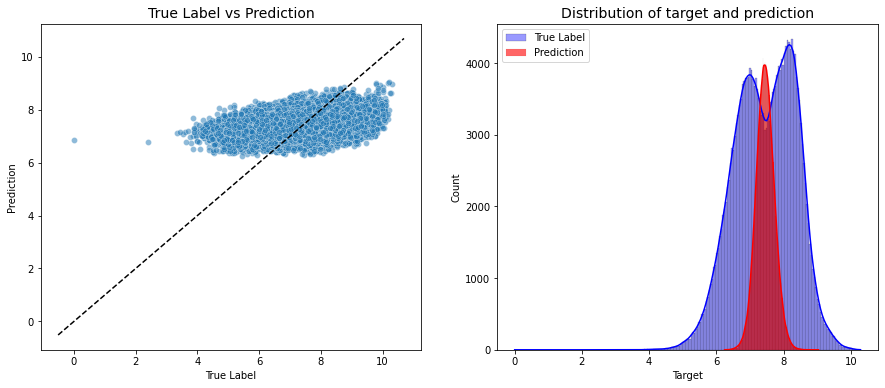

CPU times: user 43min 2s, sys: 13.2 s, total: 43min 16s
Wall time: 8min 45s


In [28]:
%%time

params = { 'reg_lambda': 0.016, 
          'reg_alpha': 9.1, 
          'colsample_bytree': 0.3, 
          'subsample': 1.0, 
          'learning_rate': 0.009, 
          'max_depth': 15, 
          'min_child_samples': 142, 
          'num_leaves': 84, 
          'random_state': 42}

full_pipe = Pipeline([('scaler', tml.DfScaler())])

mod = lgb.LGBMRegressor(n_estimators=10000, **params)

train_param = {'trsf_pipe': full_pipe, 'estimator': mod, 'early_stopping': 1000}

iterator = Iterator(train_set, test_set, y, SEEDS, 10, train_param, y_test, True)

oof, preds = iterator.it_seeds()

plot_regression_predictions(train_set, y, oof)

SEED: 541
	Iteations for early stopping: [2441, 2576, 2581, 2833, 2037, 3234, 2836, 2678, 2294, 2643]
	Train set RMSE: 0.8424
	Test set RMSE: 0.8428
SEED: 75
	Iteations for early stopping: [2631, 2735, 2729, 1950, 3336, 2313, 2533, 2473, 2662, 3452]
	Train set RMSE: 0.8423
	Test set RMSE: 0.8428
Train set RMSE: 0.8421
Test set RMSE: 0.8428


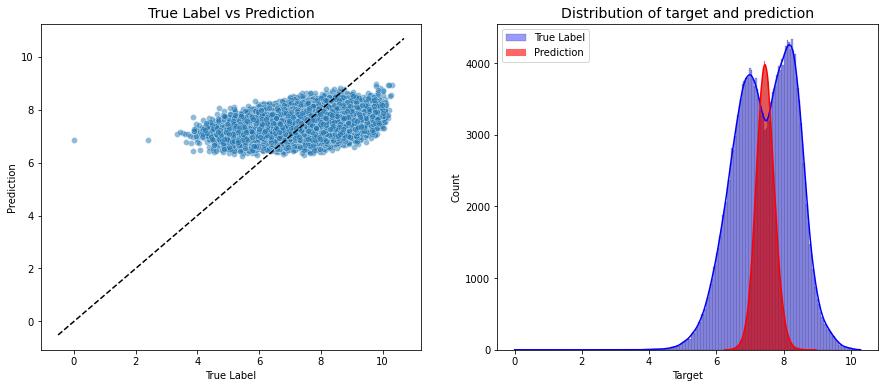

CPU times: user 42min 34s, sys: 13.1 s, total: 42min 47s
Wall time: 8min 46s


In [29]:
%%time

params = {'max_depth': 16, 
               'subsample': 0.8, 
               'colsample_bytree': 0.2, 
               'learning_rate': 0.01, 
               'reg_lambda': 11, 
               'reg_alpha': 17, 
               'min_child_samples': 31, 
               'num_leaves': 66, 
               'max_bin': 522, 
               'cat_smooth': 81, 
               'cat_l2': 0.03, 
               'metric': 'rmse', 
               'n_jobs': 5}


full_pipe = Pipeline([('scaler', tml.DfScaler())])

mod = lgb.LGBMRegressor(n_estimators=10000, **params)

train_param = {'trsf_pipe': full_pipe, 'estimator': mod, 'early_stopping': 1000}

iterator = Iterator(train_set, test_set, y, SEEDS, 10, train_param, y_test, True)

oof, preds = iterator.it_seeds()

plot_regression_predictions(train_set, y, oof)